# Project 2: Sequence Alignment and Analysis


   <div class="alert alert-block alert-danger">
    <center>Due: <b>Thursday, 24 February, 7:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    For this assignment, you are encouraged to work with one other person. Your team must satisfy these constraints:
    
   1. You **did not work together on Project 1**.
   2. You and your partner have a **total number of siblings that is divisible by two** (e.g., if you have one sibling, you need to find a partner with 1, 3, 5, or 7 siblings. If anyone has more than 7 siblings, they can partner with anyone!)
    
We expect most students will have the best learning experience on this assignment by working with a partner, but if you prefer to work alone it is okay to do this assignment on your own.
    
You are permitted (actually _encouraged_) to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from any other students in the class (other than your collaboration with your partner), and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>
</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
</div>

 <div class="alert alert-block alert-warning">
    
<b>Submission</b>: You should work on this assignment by following the directions provided at https://computingbiology.github.io/project2 (note that these are different, and somewhat more complicated than Project 1, but enable you to have a non-public repository for your project). Add the other teammate to as a collaborator with write access (also under the Settings tab) to this repository.
    
You should answer the questions and write your code in this Jupyter Notebook. (It is find if you prefer to organize your work some other way, but if you do, make sure your answers are clear in this notebook and you put everything needed to run your code in your repository.) Parts where you are expected to provide an answer (which could be text that can be written in markdown format in the notebook or Python code that runs in the notebook) are marked in green.
        
When you are ready to submit the assignment, you should create a release of the version you are submitting ([github's directions for how to create a release](https://docs.github.com/en/repositories/releasing-projects-on-github/managing-releases-in-a-repository)) tagged as `submit`. If you followed the directions to share with the course staff when you created your repository, it should already be visible to us. Then, send a message in slack to a channel that includes both team members (so the one sending this message should include the other team member) and all of the course staff (`dave`, `Hyun Jae Cho`, and `Anshuman Suri`) and a link to your repository (feel free to add any other useful comments if you want, but the link to your submission repository is sufficient).
    </div>

## Getting Started

Install basic required packages, should be run only once. You may need to restart the jupyter python kernel (under the Kernel menu) after this. (You can execute this directly in the notebook but running the command below.)

In [13]:
%pip install -r requirements.txt

  Cloning https://github.com/iamgroot42/blosum.git to /private/var/folders/bv/n177p7rs6039v5q0msyhqw8c0000gn/T/pip-req-build-zyfc1aj_
  Running command git clone --filter=blob:none -q https://github.com/iamgroot42/blosum.git /private/var/folders/bv/n177p7rs6039v5q0msyhqw8c0000gn/T/pip-req-build-zyfc1aj_
  Resolved https://github.com/iamgroot42/blosum.git to commit 433ed2f1b55fa010ad1b4b2a84158c1f38ddeaf6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [427]:
import numpy as np
import blosum as bl
import networkx as nx
import matplotlib.pyplot as plt
import utils
from functools import partial
from itertools import chain
from IPython.display import clear_output

## Part 1: Global Sequence Alignment

Below we provide the sequence alignment code from [Class 5](https://computingbiology.github.io/class5/) and [Class 6](https://computingbiology.github.io/class5/). You are welcome to use and modify this code however you want in your solution, and should answer the questions below based on this provided code.

In [15]:
def simpleMatch(a, b):
    return 1 if a == b else -1

def distanceMatch(a, b):
    return 0 if a == b else -1

def linearGap(n):
    return -1 * n

def alignmentScore(s1, s2, gapPenalty, match):
    if not s1 or not s2:
        return gapPenalty(len(s1)) + gapPenalty(len(s2))
    else:
        return max(gapPenalty(1) + alignmentScore(s1, s2[1:], gapPenalty, match), 
                   gapPenalty(1) + alignmentScore(s1[1:], s2, gapPenalty, match),
                   match(s1[0], s2[0]) + alignmentScore(s1[1:], s2[1:], gapPenalty, match)) 

In [16]:
def alignmentScoreDP(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(gapPenalty(1) + m[i, j - 1],  
                          gapPenalty(1) + m[i - 1, j],    
                          match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1]) 
    return m
    
def readAlignment(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = "" 
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            score += match(s1[i], s2[j])
            s1a = s1[i] + s1a
            if s1[i] == s2[j]:
                s2a = s2[j] + s2a
            else:
                s2a = s2[j].lower() + s2a
        elif i > 0 and m[i, j] == m[i - 1, j] + gapPenalty(1):
            i = i - 1
            score += gapPenalty(1)
            s1a = s1[i] + s1a
            s2a = '-' + s2a
        elif j > 0 and m[i, j] == m[i, j - 1] + gapPenalty(1):
            j = j - 1
            score += gapPenalty(1)
            s1a = '-' + s1a
            s2a = s2[j] + s2a
        else:
            assert False
    return (s1a, s2a, score)

def showAlignment(s1, s2, gapPenalty, match):
    m = alignmentScoreDP(s1, s2, gapPenalty, match)
    r = readAlignment(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [17]:
# Example
r = showAlignment("GATT", "GCAT", linearGap, simpleMatch)

G-ATT
GCA-T
1


Here's the version that supports affine gap penalties (from Class 6):

In [18]:
def alignmentScoreDPG(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):         
            m[i, j] = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i)),   
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
    return m
    
def readAlignmentG(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2a[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)

def showAlignmentG(s1, s2, gapPenalty, match):
    m = alignmentScoreDPG(s1, s2, gapPenalty, match)
    r = readAlignmentG(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [39]:
def affineGap(n, gp = -1, gn = -0.2):
    return gp + (n - 1) * gn

In [47]:
# Example
s1 = "AAAGAATTCA"
s2 = "AAATCA"
r = showAlignmentG(s1, s2, affineGap, simpleMatch)

AAAGAATTCA
AAA----TCA
4.4


<div class="alert alert-success">

**Problem 1 (a).** Run the given algorithm to find a global sequence alignment for the OCA2 genes (a key gene for the production of melanin) for humans and mice with the following gap penalties (still using simpleMatch as the match score function):

  a. `linearGap` penalty
    
  b. `affineGap` penalty, with $gp=-0.2$

  c. `affineGap` penalty, with $gp=-0.1$
    
</div>


In [36]:
human_oca2, mouse_oca2 = utils.load_oca2_sequences()

In [49]:
# Your code here
a = showAlignmentG(human_oca2,mouse_oca2,linearGap, simpleMatch)

affineGap2 = partial(affineGap,gp = - 0.2)
b = showAlignmentG(human_oca2,mouse_oca2,affineGap2, simpleMatch)

affineGap3 = partial(affineGap,gp = - 0.1)
c = showAlignmentG(human_oca2,mouse_oca2,affineGap3, simpleMatch)

-GTTCT--TACTTCGAAG-GCTGTGCTCCG----CTCACCATCCAGAGCGGAGGTGCGGACC-T-TA-AACTCA-CTCC--TGGA----GA-A--AGATCTGCAAGTGC-GCAGAGAGAAGACTGGCAGTGGAGCATGCATCTGGAGGGCAGAGACGGC-A-GGCGGTACCCCGGCGCGCCGGCG-GTGGAGCTCCTGCAGACGTCCGTGCC-CAGCGGACTCGCT-GAACTTGTGGC--CGGCA-AGC
cccTCTCAggCTgC-AAGtGC-cTGCTgaGtCTcCTtA-CA-CC--AG-GGttGTGC--tCCATGcACgACTCATagCCAATGGA-GA-GAGAtGAGA-CTtC-AcTGCCG--GAGAG-AGA-T--CAG-cGAG--T-CATC---A-GaCAGA-tCaGCAGG-GG-A--CatGCGC-CtaGaGacaaAG-aCaT-CAG--G-CtG-GCCCAGCcG--T-GCTGAAgTaG-aGCCacCAA-C
25
---------G-T-----T-C-T--T---A---CTT-CGA--A-GG-CTGTGCTCC--GCTCAC--CATCCAGAG-C---GGAGGTGC-GGAC-CTTAA-AC-TCACT-CCTGGAGA-AAGATC-TGC-AAGTGC--GCAGA-GAGA--AG--ACTGGCAGTGGAGCAT--GCATCT-G-G-AGGGC-AGAGAC--GGCAGGC-GGTACCC-C-GGCGCG-CCGGCGGTGG-AGCTCCTGCAGACGTCCGTGCCCAGCGGACTCGCTGAACTTGTGGCCGGCAAGC
--T-TTC-TGTTTCC-TT-CATATTTCCACA-CTTGC-AGGATGGA-TGTGCTCCCG-C-CAC-GC-T-CAGAGACGCGGGA--T-C-GGACCCT--AAAC-TCACT--CTGGAGA--AGATC--GC--AGT-C---CAGA--AGAAGAC-G---G-GGA-CATGC--CTGGA---CA-AGAC--CAGGCGG---CCC-GC-CG---GC--TGGAG---

<div class="alert alert-success">

**Problem 1 (b).** Use the given function to convert these sequences to their amino-acid sequences, and then re-run alignment for all sequences with the default parameters for `affineGap`.
</div>


In [11]:
# Convert sequence of nucleotides to amino acids using codon table lookup
# Example
utils.convert_to_amino("AAATGCGGCGTA")

'KCGV'

In [51]:
# Your code here
human_oca2_amino = utils.convert_to_amino(human_oca2)
mouse_oca2_amino = utils.convert_to_amino(mouse_oca2)

a = showAlignmentG(human_oca2_amino,mouse_oca2_amino,affineGap,simpleMatch)

VLTSKAVLRS-----------PSRAEVRTLNSL----L-----E------KDLQVR----RE----------KTGSGACIWRAETAGGTPARRRWSSCRRPCPADSLNLWPAS
--pSgA--aS-TtqSLS---LPS-----TtqSLS---L--TP-E-----DtD-QqRRE--GS-----RA-----TP--------------D--------
-13.799999999999999


## Part 2: Alignment with Amino-Acids


The PAM<em>n</em> matrix (covered in [Class 5](https://computingbiology.github.io/class5/)) represents the likelihood of the occurrence of each tranformation during a time period where there are _n_ total mutation events per 100 amino acids.

<div class="alert alert-success">

**Problem 2 (a)** What would a negative value of an entry in a PAM 1 matrix $M$ indicate? Explain in terms of evolution and functionality of the proteins. Note that $M_{ij} = log(\frac{q_{ij}}{p_ip_j})$ where $q_{ij}$ indicates the frequency of amino acids $i$ and $j$ observed to align in related sequences, and $p_i$ and $p_j$ represent the frequencies of occurrence of $i$ and $j$.
</div>

A negative value means that the the numerator is less than the denominator, or in this case that the frequency of the chance alignment of the amino acids, the denominator, is greater than the frequency of a point mutation changing one of the amino acids to other (indicating that the sequences might be related).

<div class="alert alert-success">
    
**Problem 2 (b).** The BLOSUM<em>x</em> matices are created by clustering sequences with more than <em>x</em>% similarity into one single sequence and comparing sequences with more than <em>x</em>% divergence. Therefore, BLOSUM matrices are based on local alignments. Which of BLOSUM 50 and 60 contain more evoluationary divergence? 
    
</div>

BLOSUM50 because it is sequences with at most 50% similarity versus sequences with at most 60% similarity.

<div class="alert alert-success">

**Problem 2 (c).** Use the BLOSUM62 matrix as your scoring function to perform global alignment on the amino-acid sequences using `linearGap` (default parameters).
</div>

In [774]:
blosum_matrix = bl.BLOSUM(62)

def blosum(blosum_matrix,a,b):
    if (blosum_matrix[a+b] == "QQ")
    return blosum_matrix[a + b]
   
print(blosum)
blosum2 = partial(blosum,blosum_matrix)
a = showAlignmentG(human_oca2_amino,mouse_oca2_amino,affineGap,blosum2)

<function blosum at 0x7faa003f9d30>
VLTSKAVLRSPS---RA--EVRTLNSLLEKDLQVRREKTGSGAC---------IWRAE-TAG------------G-TPAR--R-RWS--SCR---R--PCPADSLNLWPAS
----------PS--EsA--Ei--Lh-------Q--------G-CaS-RRP---IWtldTAGGaP-RRq-aS-RRP---D--------
96.19999999999999


_Type your answer here_

<div class="alert alert-success">

**Problem 2 (d).** How do your results for Problem 2c differ from the earlier ones of Problem 1a (with `linearGap`)? Which one would you say is more biologically plausible?
</div>

They are are of a much higher alignment score, which makes more biological sense because we know that the proteins are homologous.

<div class="alert alert-success">

**Problem 2 (e).** We discussed in class that the PAM matrices follow the Markov property and a mismatch at any site depends only on the amino acid at that site and the transition probability. Is this a suitable representation of evolution? Think about if replacements are equaly likely to occur over entire sequences. It may help to consider the difference between PAM and BLOSUM matrices.
</div>

No, this isn't a good representation of evolution because PAM matrices only consider point mutations.  BLOSUM matrices consider changes to amino acids, which are more functionally related to biological evolution since mutations that don't cause change to amino acids and only bases are more likely to not be detrimental and conserved in the evolutionary line.  Additionally, higher-order changes than just amino acid substitions would have to be consdiered as well for an even more accurate picture since the secondary, tertiary, and quaternary structures and by extension functin of proteins are determined by the sequences of amino acids whereas a single change in amino acid residue may not fully disably or alter protein function sufficiently to create evolutionary pressure.

## Part 3: Local Sequence Alignment


<div class="alert alert-success">
    
<b>Problem 3 (a).</b> Implement local alignment (for both the normal and affine-gap penalties) using the Smith-Waterman algorithm. Feel free to re-use and modify the given Needleman–Wunsch algorithm. 
</div>

In [406]:
def alignmentScoreLocal(s1, s2, gapPenalty, match):   
    H = np.zeros((len(s1) + 1, len(s2) + 1));
    for k in range(1,max(len(s1) + 2,len(s2) + 2)):
        for j in range(1,min(k,len(s2) + 1)):
            for i in range(k-1,min(k,len(s1) + 1)):
                H[i, j] = max(gapPenalty(1) + H[i, j - 1], gapPenalty(1) + H[i - 1, j], match(s1[i-1], s2[j-1]) + H[i - 1, j - 1],0)
                           
        for i in range(1,min(k,len(s1))):
            for j in range(k-1,min(k,len(s2))):
                H[i, j] = max(gapPenalty(1) + H[i, j - 1],
                              gapPenalty(1) + H[i - 1, j], 
                              match(s1[i-1], s2[j-1]) + H[i - 1, j - 1],
                                   0)
    return H;
                
#                 max(chain((gapPenalty(g) + H[i, j - g] for g in range(1, j)),
#                               (gapPenalty(g) + H[i - g, j] for g in range(1, i)), 
#                                [(match(s1[i-1], s2[j-1]) + H[i - 1, j - 1])],
#                                    [0])) 
                
    
def readAlignmentLocal(s1, s2, m, gapPenalty, match):
    maxM = np.amax(m)
    indexCoord = np.where(m == maxM)
#     otherPossibilities = []
#     otherStrings1 = []
#     otherStrings2 = []
    i = indexCoord[0][0]
    j = indexCoord[1][0]
    score = maxM
    s1a = ""
    s2a = ""
#     s1b = ""
#     s2b = ""
#     exploredAll = 0
    
#     for k in range(1,len(indexCoord[0])):
#         otherPossibilities.append((indexCoord[0][i],indexCoord[1][i]))
#         otherStrings1.append("")
#         otherStrings2.append("")
    
    
#     while not exploredAll:
#         if len(otherStrings1) == 0:
#             exploredAll = 1
#         else:
#             print("new")
#             i,j = otherPossibilities.pop(0)
#             s1a = otherStrings1.pop(0)
#             s2a = otherStrings2.pop(0)

    for z in range(1,2):
        while m[i,j] != 0:
            gap = 1;
            diag = (m[i-1,j-1] + match(s1[i-1],s2[j-1])) == m[i,j]
            up = (m[i-1,j] + gapPenalty(gap)) == m[i,j]
            left = (m[i,j-1] + gapPenalty(gap)) == m[i,j]
            if (max(m[i-1,j] * up,m[i-1,j-1] * diag,m[i,j-1] * left) == m[i-1,j-1] and diag):
                gap = 1
#                 if (m[i-1,j] == m[i-1,j-1] and m[i-1,j-1] != 0):
#                     exploredAll = 0
#                     otherStrings1.append(s1[i - 1] + s1a)
#                     otherStrings2.append('-' + s2a)
#                     otherPossibilities.append((i-1,j))
#                 if (m[i,j-1] == m[i-1,j-1] and m[i-1,j-1] != 0):
#                     exploredAll = 0
#                     otherStrings1.append('-' + s1a)
#                     otherStrings2.append(s2[j-1] + s2a)
#                     otherPossibilities.append((i,j-1))
                s1a = s1[i - 1] + s1a
                s2a = s2[j - 1] + s2a
                j = j - 1
                i = i - 1
#                 print("diag")
            elif (max(m[i-1,j] * up,m[i-1,j-1] * diag,m[i,j-1] * left) == m[i-1,j] and up):
                gap = gap + 1
#                 if (m[i,j-1] == m[i-1,j] and m[i-1,j] != 0):
#                     exploredAll = 0
#                     otherStrings1.append('-' + s1a)
#                     otherStrings2.append(s2[j-1] + s2a)
#                     otherPossibilities.append((i,j-1))
                s1a = s1[i - 1] + s1a
                s2a = '-' + s2a
                i = i - 1
#                 print("up")
            elif (max(m[i-1,j] * up,m[i-1,j-1] * diag,m[i,j-1] * left) == m[i,j-1] and left):
                gap = gap + 1
                s1a = '-' + s1a
                s2a = s2[j - 1] + s2a
                j = j - 1 
#                 print("left")
#         if(len(s1a) > len(s1b)):
#             s1b = s1a
#             s2b = s2a
#             print(s1b + " " + s2b)
    return(s1a,s2a,score)

def showAlignmentLocal(s1, s2, gapPenalty, match):
    m = alignmentScoreLocal(s1, s2, gapPenalty, match)
    r = readAlignmentLocal(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m,r)

We've included some assert statements that can help you check the correctness of your algorithm. As with any algorithm, correctness on these test inputs does not guarantee algorithmic correcntess, but can be useful to debug.

In [407]:
# Example expected output
# Taken from https://en.wikipedia.org/wiki/Smith–Waterman_algorithm)
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)

GTTGAC
GTT-AC
4.0


In [408]:
# First assert
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)
print(r[1][2])
assert (r[1][2] == 4 and "GTTGAC" in r[1][0] and "GTT-AC" in r[1][1])

# Second assert
r = showAlignmentLocal("GGACTTAAATAGA", "TGTTGGTGATCCACGTGG", linearGap, simpleMatch)
assert (r[1][2] == 2 and "GG" == r[1][0] and "GG" == r[1][1])

# Third assert
r = showAlignmentLocal("TTGA", "GGCC", linearGap, simpleMatch)
assert (r[1][2] == 1 and "G" == r[1][0] and "G" == r[1][1])

# Fourth assert
r = showAlignmentLocal("TACGGGCCCGCTAC", "TAGCCCTATCGGTCA", linearGap, simpleMatch)
assert (r[1][2] == 4 and "TA-CGG" in r[1][0] and "TATCGG" in r[1][1])

GTTGAC
GTT-AC
4.0
4.0
GG
GG
2.0
G
G
1.0
TA-CGG
TATCGG
4.0


<div class="alert alert-success">
    
<b>Problem 3 (b).</b> Align the provided hemoglobin genes for:
    <ol>
        <li>`polar bears` & `black bears`,</li>
        <li>`humans` & `chimps`,</li>
        <li>`polar bears` & `humans`, and</li>
        <li>`black bears` & `chimps`.</li>
    </ol>

Use `linearGap`.
    
Take note of the scores you get. What do you notice?
</div>

In [409]:
polar_bear, black_bear, human, chimp = utils.get_hemoglobin_sequences()

In [411]:
# Your code here
#a = showAlignmentLocal(polar_bear,black_bear,linearGap,simpleMatch)
r = showAlignmentLocal(polar_bear, black_bear, linearGap, simpleMatch)
r = showAlignmentLocal(human, chimp, linearGap, simpleMatch)
r = showAlignmentLocal(polar_bear, human, linearGap, simpleMatch)
r = showAlignmentLocal(black_bear, chimp, linearGap, simpleMatch)
print(polar_bear)
print(black_bear)

AAATGCTGGCGCACTCCCCGCCCCGCACATTTCTGGTCCTCACAGACTCAGAAAGAAGCCACCATGGTGCTGTCTCCCGCCGACAAGAGCAACGTCAAGGCCACCTGGGATAAGATCGGCAGCCACGCTGGCGAGTATGGCGGCGAGGCTCTGGAGAGGTGAGGACCCAACCTTCCCCTGTCGGGGTCAGGGCTCCGCCACCCCCCCGGCCCTTGTCCTCCACCGCCCACCTAACCCCGGCTCACCCACGCCTTCCTCCCGCAGGACCTTCGCGTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCTGAGCCCTGGCTCCGCCCAGGTCAAGGCCCACGGCAAGAAGGTGGCCGACGCCCTGACCACCGCCGCAGGCCACCTGGACGACCTGCCGGGCGCCCTGTCCGCTCTGAGCGACCTGCACGCGCACAAGCTGCGAGTGGACCCGGTCAACTTCAAGGTGAGCACGCGGGCCGGCGCGGAGAGACCTGGGGCAGGAGGGCGCAGCGAACCCTGCTAGCAGGACGGGGAGTCCCTTGGGCTGCGGAAGGTGGAGCGCGGGCGGGCGGCCGCGTCCCCCGACGGCCCCTGACGTCCCCTGTCTCCGCAGTTCCTGAGCCACTGCCTGCTGGTGACCCTGGCCAGCCACCACCCCGCGGAGTTCACCCCTGCCGTCCACGCCTCCCTGGACAAGTTCTTCAGCGCCGTGAGCACCGTGCTCACCTCCAAATACCGTTAAGCTGGAGCCGCGCGACCCTCCCGCTCCCGGCCTGGGGCCTCTTGCGCTCCACGCGCCTGAACTTCCCGATCTTTGAATAAAGTCTGAGTGGGCTGCA
AAATGCTGGCGCACTCCCCGCCCCGCACATTTCTGGTCCTCACAGACTCAGAAAGAAGCCACCATGGTGCTGTCTCCCGCCGACAAGAGCAACGTCAAGGCCACCTGGGATAAGATTGGCAGCCACGCTGGCGAGTATGGCGGCGAGGCTCTGG

_Type your answer here_

<div class="alert alert-success">

<b>Problem 3 (c).</b> Use <a href="https://blast.ncbi.nlm.nih.gov/">BLAST</a> for the above pairs of sequences. Carefully inspect the returned results to see if they are similar to the alignments you obtained above.
</div>

Polar/Black Bear: 
Score:411 bits(222), Expect:9e-119, 
Identities:226/228(99%),  Gaps:0/228(0%), Strand: Plus/Plus

Query  624  AGTTCCTGAGCCACTGCCTGCTGGTGACCCTGGCCAGCCACCACCCCGCGGAGTTCACCC  683
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  362  AGTTCCTGAGCCACTGCCTGCTGGTGACCCTGGCCAGCCACCACCCCGCGGAGTTCACCC  421

Query  684  CTGCCGTCCACGCCTCCCTGGACAAGTTCTTCAGCGCCGTGAGCACCGTGCTCACCTCCA  743
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  422  CTGCCGTCCACGCCTCCCTGGACAAGTTCTTCAGCGCCGTGAGCACCGTGCTCACCTCCA  481

Query  744  AATACCGTTAAGCTGGAGCCGCGCGACCCTCCCGCTCCCGGCCTGGGGCCTCTTGCGCTC  803
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  482  AATACCGTTAAGCTGGAGCCGCGCGACCCTCCCGCTCCCGGCCTGGGGCCTCTTGCGCTC  541

Query  804  CACGCGCCTGAACTTCCCGATCTTTGAATAAAGTCTGAGTGGGCTGCA  851
            | ||| ||||||||||||||||||||||||||||||||||||||||||
Sbjct  542  CGCGCACCTGAACTTCCCGATCTTTGAATAAAGTCTGAGTGGGCTGCA  589




Range 2: 157 to 363

Score:377 bits(204), Expect:9e-109, 
Identities:206/207(99%),  Gaps:0/207(0%), Strand: Plus/Plus

Query  269  AGGACCTTCGCGTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCTGAGCCCT  328
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  157  AGGACCTTCGCGTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCTGAGCCCT  216

Query  329  GGCTCCGCCCAGGTCAAGGCCCACGGCAAGAAGGTGGCCGACGCCCTGACCACCGCCGCA  388
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
Sbjct  217  GGCTCCGCCCAGGTCAAGGCCCACGGCAAGAAGGTGGCCGACGCCCTGACCACCGCCGCG  276

Query  389  GGCCACCTGGACGACCTGCCGGGCGCCCTGTCCGCTCTGAGCGACCTGCACGCGCACAAG  448
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  277  GGCCACCTGGACGACCTGCCGGGCGCCCTGTCCGCTCTGAGCGACCTGCACGCGCACAAG  336

Query  449  CTGCGAGTGGACCCGGTCAACTTCAAG  475
            |||||||||||||||||||||||||||
Sbjct  337  CTGCGAGTGGACCCGGTCAACTTCAAG  363




Range 3: 1 to 159

Score:289 bits(156), Expect:4e-82, 
Identities:158/159(99%),  Gaps:0/159(0%), Strand: Plus/Plus

Query  7    AAATGCTGGCGCACTCCCCGCCCCGCACATTTCTGGTCCTCACAGACTCAGAAAGAAGCC  66
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  1    AAATGCTGGCGCACTCCCCGCCCCGCACATTTCTGGTCCTCACAGACTCAGAAAGAAGCC  60

Query  67   ACCATGGTGCTGTCTCCCGCCGACAAGAGCAACGTCAAGGCCACCTGGGATAAGATCGGC  126
            |||||||||||||||||||||||||||||||||||||||||||||||||||||||| |||
Sbjct  61   ACCATGGTGCTGTCTCCCGCCGACAAGAGCAACGTCAAGGCCACCTGGGATAAGATTGGC  120

Query  127  AGCCACGCTGGCGAGTATGGCGGCGAGGCTCTGGAGAGG  165
            |||||||||||||||||||||||||||||||||||||||
Sbjct  121  AGCCACGCTGGCGAGTATGGCGGCGAGGCTCTGGAGAGG  159


Human/Chimp:
Score:1434 bits(776), Expect:0.0, 
Identities:822/843(98%),  Gaps:8/843(0%), Strand: Plus/Plus

Query  1    ACTCTTCTGGTCCCCACAGACTCAGAGAGAACCCACCATGGTGCTGTCTCCTGCCGACAA  60
            |||||||||||||||||||||||||| |||||||||||||||||||||||||||||||||
Sbjct  1    ACTCTTCTGGTCCCCACAGACTCAGAAAGAACCCACCATGGTGCTGTCTCCTGCCGACAA  60

Query  61   GACCAACGTCAAGGCCGCCTGGGGTAAGGTCGGCGCGCACGCTGGCGAGTATGGTGCGGA  120
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  61   GACCAACGTCAAGGCCGCCTGGGGTAAGGTCGGCGCGCACGCTGGCGAGTATGGTGCGGA  120

Query  121  GGCCCTGGAGAGGTGAGGCTCCCTCCCCTGCTCCGACCCGGGCTCCTCGCCCGCCCGGAC  180
            |||||||||||||||||||||||||||||||||||||||||||||||||||||||| |||
Sbjct  121  GGCCCTGGAGAGGTGAGGCTCCCTCCCCTGCTCCGACCCGGGCTCCTCGCCCGCCCTGAC  180

Query  181  CCACAGGCCACCCTCAACCGTCCTGGCCCCGGACCCAAACCCCACCCCTCACTCTGCTTC  240
            |||||||||||||||| | ||||||||||||| |||||||||||||||||||||||||||
Sbjct  181  CCACAGGCCACCCTCAGCGGTCCTGGCCCCGGCCCCAAACCCCACCCCTCACTCTGCTTC  240

Query  241  TCCCCGCAGGATGTTCCTGTCCTTCCCCACCACCAAGACCTACTTCCCGCACTTCGACCT  300
            |||||||||||||||||||||||||||||||||||||||||||||||| |||||||||||
Sbjct  241  TCCCCGCAGGATGTTCCTGTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCT  300

Query  301  GAGCCACGGCTCTGCCCAGGTTAAGGGCCACGGCAAGAAGGTGGCCGACGCGCTGACCAA  360
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  301  GAGCCACGGCTCTGCCCAGGTTAAGGGCCACGGCAAGAAGGTGGCCGACGCGCTGACCAA  360

Query  361  CGCCGTGGCGCACGTGGACGACATGCCCAACGCGCTGTCCGCCCTGAGCGACCTGCACGC  420
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  361  CGCCGTGGCGCACGTGGACGACATGCCCAACGCGCTGTCCGCCCTGAGCGACCTGCACGC  420

Query  421  GCACAAGCTTCGGGTGGACCCGGTCAACTTCAAGGTGAGCGGCGGGCCGGGAGCGATCTG  480
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  421  GCACAAGCTTCGGGTGGACCCGGTCAACTTCAAGGTGAGCGGCGGGCCGGGAGCGATCTG  480

Query  481  GGTCGAGGGGCGAGATGGCGCCTTCCTCGCAGGGCAGAGGATCACGCGGGTTGCGGGAGG  540
            |||||||||||||||||||||||||||||||||||||||||||||||| |||||||||||
Sbjct  481  GGTCGAGGGGCGAGATGGCGCCTTCCTCGCAGGGCAGAGGATCACGCGAGTTGCGGGAGG  540

Query  541  TGTAGCGCAGGCGGCGGCTGCGGGCCTGGGCCCTCGGCCCCACTGACCCTCTTCTCTGCA  600
            |||||||||||||||||||||||||||||||  |     |||||||||||||||||||||
Sbjct  541  TGTAGCGCAGGCGGCGGCTGCGGGCCTGGGC--T-----CCACTGACCCTCTTCTCTGCA  593

Query  601  CAGCTCCTAAGCCACTGCCTGCTGGTGACCCTGGCCGCCCACCTCCCCGCCGAGTTCACC  660
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  594  CAGCTCCTAAGCCACTGCCTGCTGGTGACCCTGGCCGCCCACCTCCCCGCCGAGTTCACC  653

Query  661  CCTGCGGTGCACGCCTCCCTGGACAAGTTCCTGGCTTCTGTGAGCACCGTGCTGACCTCC  720
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Sbjct  654  CCTGCGGTGCACGCCTCCCTGGACAAGTTCCTGGCTTCTGTGAGCACCGTGCTGACCTCC  713

Query  721  AAATACCGTTAAGCTGGAGCCTCGGTGGCCATGCTTCTTGccccttgggcctccccccag  780
            ||||||||||||||||||||||||||||||||||||||||||||||||||||| | ||||
Sbjct  714  AAATACCGTTAAGCTGGAGCCTCGGTGGCCATGCTTCTTGCCCCTTGGGCCTCTCGCCAG  773

Query  781  cccctcctccccttcctgcacccgtacccccG-TGGTCTTTGAATAAAGTCTGAGTGGGC  839
             |||||||| |||||||||||| ||||||||  |||||||||||||||||||||||||||
Sbjct  774  GCCCTCCTCTCCTTCCTGCACCTGTACCCCCCCTGGTCTTTGAATAAAGTCTGAGTGGGC  833

Query  840  GGC  842
            |||
Sbjct  834  GGC  836


Polar Bear/Human:

Score:510 bits(276), Expect:1e-148, 
Identities:599/747(80%),  Gaps:54/747(7%), Strand: Plus/Plus

Query  37   TTCTGGTCCTCACAGACTCAGAAAGAAGCCACCATGGTGCTGTCTCCCGCCGACAAGAGC  96
            ||||||||| |||||||||||| |||| ||||||||||||||||||| |||||||||| |
Sbjct  5    TTCTGGTCCCCACAGACTCAGAGAGAACCCACCATGGTGCTGTCTCCTGCCGACAAGACC  64

Query  97   AACGTCAAGGCCACCTGGGATAAGATCGGCAGC-CACGCTGGCGAGTATGGCGGCGAGGC  155
            |||||||||||| |||||| |||| ||||| || ||||||||||||||||| |  |||||
Sbjct  65   AACGTCAAGGCCGCCTGGGGTAAGGTCGGC-GCGCACGCTGGCGAGTATGGTGCGGAGGC  123

Query  156  TCTGGAGAGGTGAGGACCCAACCTTCCCCTG-TCGGGGTCAGGGCTCCGCCAcccccccG  214
             |||||||||||||| | |  || ||||||| ||  |  | |||||||  | ||| ||||
Sbjct  124  CCTGGAGAGGTGAGG-CTC--CC-TCCCCTGCTC-CGACCCGGGCTCC-TCGCCCGCCCG  177

Query  215  G-CCC-TTGTCC-TCCACCGCCCACCTAACCCCGG-CTC--A-CCCA---CGC-CT-T-C  261
            | |||   | ||  || |  ||  |||  |||||| | |  | ||||   | | || | |
Sbjct  178  GACCCACAGGCCACCCTCAACCGTCCTGGCCCCGGACCCAAACCCCACCCCTCACTCTGC  237

Query  262  --CT-CCCGCAGGACCTTCGCGTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGA  318
              || |||||||||  |||  |||||||||||||||||||||||||||||| ||||||||
Sbjct  238  TTCTCCCCGCAGGATGTTCCTGTCCTTCCCCACCACCAAGACCTACTTCCCGCACTTCGA  297

Query  319  CCTGAGCCCTGGCTCCGCCCAGGTCAAGGCCCACGGCAAGAAGGTGGCCGACGCCCTGAC  378
            ||||||||  ||||| |||||||| |||| |||||||||||||||||||||||| |||||
Sbjct  298  CCTGAGCCACGGCTCTGCCCAGGTTAAGGGCCACGGCAAGAAGGTGGCCGACGCGCTGAC  357

Query  379  CACCGCCGCAGGC-CACCTGGACGACCTGCCGGGCGCCCTGTCCGCTCTGAGCGACCTGC  437
            || |||||  ||| ||| |||||||| ||||   ||| |||||||| |||||||||||||
Sbjct  358  CAACGCCGT-GGCGCACGTGGACGACATGCCCAACGCGCTGTCCGCCCTGAGCGACCTGC  416

Query  438  ACGCGCACAAGCTGCGAGTGGACCCGGTCAACTTCAAGGTGAGCACGCGGGCCGGCGCGG  497
            ||||||||||||| || |||||||||||||||||||||||||||  ||||||||    ||
Sbjct  417  ACGCGCACAAGCTTCGGGTGGACCCGGTCAACTTCAAGGTGAGCG-GCGGGCCG----GG  471

Query  498  AGAGACCTGGGGC-AGGAGGGCGCAGCGAAC-CCTGC-TAGCAGGACGG-GGAGTCCCTT  553
            || || ||||| | ||| || || ||    | ||| | | ||||| | | ||| || |  
Sbjct  472  AGCGATCTGGGTCGAGG-GG-CG-AGATGGCGCCTTCCTCGCAGGGCAGAGGA-TCACGC  527

Query  554  GGGCTGCGGAAGGTGGAGCGCGGGCGGGCGGCCGCGT-CC---CCCGACGGCCCCTGAC-  608
            ||| ||||| ||||| ||||| ||||| |||| |||  ||    ||  |||||||  || 
Sbjct  528  GGGTTGCGGGAGGTGTAGCGCAGGCGG-CGGCTGCGGGCCTGGGCCCTCGGCCCC--ACT  584

Query  609  GTCCC-CTGTCTCCG--CAGTTCCTGAGCCACTGCCTGCTGGTGACCCTGGCCAGCCACC  665
            | ||| || |||| |  ||| |||| |||||||||||||||||||||||||||  |||||
Sbjct  585  GACCCTCT-TCTCTGCACAGCTCCTAAGCCACTGCCTGCTGGTGACCCTGGCCGCCCACC  643

Query  666  ACCCCGCGGAGTTCACCCCTGCCGTCCACGCCTCCCTGGACAAGTTCTTCAGCGCC-GTG  724
             |||||| |||||||||||||| || ||||||||||||||||||||| |  ||  | |||
Sbjct  644  TCCCCGCCGAGTTCACCCCTGCGGTGCACGCCTCCCTGGACAAGTTCCTG-GCTTCTGTG  702

Query  725  AGCACCGTGCTCACCTCCAAATACCGT  751
            ||||||||||| |||||||||||||||
Sbjct  703  AGCACCGTGCTGACCTCCAAATACCGT  729

Black Bear/Chimp:
Score:257 bits(139), Expect:1e-72, 
Identities:177/196(90%),  Gaps:0/196(0%), Strand: Plus/Plus

Query  168  GTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCTGAGCCCTGGCTCCGCCCA  227
            |||||||||||||||||||||||||||||||||||||||||||||||  ||||| |||||
Sbjct  259  GTCCTTCCCCACCACCAAGACCTACTTCCCCCACTTCGACCTGAGCCACGGCTCTGCCCA  318

Query  228  GGTCAAGGCCCACGGCAAGAAGGTGGCCGACGCCCTGACCACCGCCGCGGGCCACCTGGA  287
            ||| |||| |||||||||||||||||||||||| ||||||| ||||| ||  ||| ||||
Sbjct  319  GGTTAAGGGCCACGGCAAGAAGGTGGCCGACGCGCTGACCAACGCCGTGGCGCACGTGGA  378

Query  288  CGACCTGCCGGGCGCCCTGTCCGCTCTGAGCGACCTGCACGCGCACAAGCTGCGAGTGGA  347
            |||| ||||   ||| |||||||| |||||||||||||||||||||||||| || |||||
Sbjct  379  CGACATGCCCAACGCGCTGTCCGCCCTGAGCGACCTGCACGCGCACAAGCTTCGGGTGGA  438

Query  348  CCCGGTCAACTTCAAG  363
            ||||||||||||||||
Sbjct  439  CCCGGTCAACTTCAAG  454


<div class="alert alert-success">

<b>Problem 3 (d).</b> Could you run an affine-gap-loss version of your local-alignment algorithm for the given sequences? How much time did BLAST take?
Can you think of any optimizations you could make to make the affine-gap-loss version run faster- perhaps utilizing parallel processing or GPUs?
</div>

Yes, you could use an affine-gap-loss version, but that would require a separate or different data structure to store the gaps needed to move forward to the next iteration since there is a difference in gap penalty.  The Blast took 1-2 seconds per run.  The affine-gap version could be made faster by parallelizing the calculations for each new element, which becomes more parallelizable as the iterations increase.  Each iteration works on column k and row k, as you increment k each iteration making a larger and large half-outline of a sqare from the top right corner.  Since the horizontal values for the column, vertical values for the row, and all diagonal values are already known, these can be parallelized.  There is the limitation in that vertical (i.e. a vertical gap) values for columns and horizontal values will have to be calculated sequentially.  

## Part 4: Phylogenetic Tree Reconstruction

For this part, we'll briefly enter a fictional setup where you want to trace the evolution of Pokémon. The data is in the format of a two lists: one each for the sequences themselves, and names of the Pokémons.

<div class="alert alert-success">
    
**Problem 4 (a).** Implement an algorithm for Phylogenetic Tree Reconstrution using the neighbor joining algorithm. Color intermediate nodes different from leaf nodes. Use given names as node labels in your visualization.
    
For computing the distances matrix, use affine-based gap-loss in your alignment score computations.
    
</div>

You can either label intermediate nodes in the Phylogenetic tree such that they start with "intermediate_" and use the given functions below, or use your own nomenclature/way of handling those node, and modify the given helper functions accordingly.

In [21]:
# Your code here


We've provided a helper function to plot a given Phylogenetic tree

In [766]:
def construct_alignment(dist, names):
    distances = dist
    nodes = nx.Graph()
    dim = len(distances)
    
    totDists = np.zeros((dim,1))
    for i in range(dim):
        totDists[i] = 0;
        for j in range(dim):
            totDists[i] = totDists[i] + distances[i,j]
            
    
    distNew = distances;
    for i in range(dim):
        for j in range(i,dim):
            distNew[i,j] = (dim - 2) * distances[i,j] - totDists[i] - totDists[j]
            distNew[j,i] = distNew[i,j]
            
            
    distances = distNew;
            
    print(totDists)
    
    
        
    for i in range(dim - 2): 
        np.fill_diagonal(distances,10^6)
        minDist = np.amin(distances)
        indexCoord = np.where(distances == minDist)
        
        if not names[indexCoord[0][0]].startswith("intermediate_"):
            nodes.add_node(names[indexCoord[0][0]])
        if not names[indexCoord[1][0]].startswith("intermediate_"):
            nodes.add_node(names[indexCoord[1][0]])
                     
        nodes.add_node('intermediate_' + str(i))
        weightVal = minDist/2 + 1/(dim - 2 - i) * (totDists[indexCoord[0][0]] - totDists[indexCoord[1][0]])
        nodes.add_edge(names[indexCoord[0][0]],'intermediate_' + str(i),weight=weightVal)
        nodes.add_edge(names[indexCoord[1][0]],'intermediate_' + str(i),weight=distances[indexCoord[0][0],indexCoord[1][0]] - weightVal)
        
        names.pop(max(indexCoord[0][0],indexCoord[1][0]))
        names.pop(min(indexCoord[0][0],indexCoord[1][0]))
        names.append('intermediate_' + str(i))
        
        distances[:,[indexCoord[1][0],dim - i - 1]] = distances[:,[dim - i - 1,indexCoord[1][0]]]
        distances[[indexCoord[1][0],dim - i - 1],:] = distances[[dim - i - 1,indexCoord[1][0]],:]
        distances[:,[indexCoord[0][0],dim - i - 2]] = distances[:,[dim - i - 2,indexCoord[0][0]]]
        distances[[indexCoord[0][0],dim - i - 2],:] = distances[[dim - i - 2,indexCoord[0][0]],:]
        distNew = np.zeros((dim - i - 1,dim - i - 1))
        
        print(totDists)
        totDists[indexCoord[1][0]] = totDists[len(totDists) - 1]
        print(totDists)
        totDists[indexCoord[0][0]] = totDists[len(totDists) - 2]
        print(totDists)
        totDists[len(totDists) - 2] = 0
        print(totDists)
        totDists = np.delete(totDists,len(totDists) - 1)
        #totDists.reshape((len(totDists ) - 1,1))
        print(totDists)
        
        for j in range(dim - i - 1):
            print(len(totDists) - 2)
            distNew[len(totDists) - 2,j] = (distances[indexCoord[0][0],j] + distances[indexCoord[1][0],j] - distances[indexCoord[0][0],indexCoord[1][0]])/2
            distNew[j,len(totDists) - 2] = distNew[len(totDists) - 2,j]
            totDists[len(totDists) - 2] = distNew[len(totDists) - 2,j]
            
        distNew[0:dim - i - 2,0:dim - i - 2] = distances[0:dim - i - 2,0:dim - i - 2] 
                
#         for j in range(dim - i - 1):
#             for k in range(i,dim - i - 1):
#                 if (k != dim - i - 2 and j != dim - i - 2):
#                     distNew[j,k] = distances[j,k]
#                 else:
#                     distNew[j,k] = 0.5 * (distances[dim - i - 2, k] + distances[k,dim - i - 1] - distances[dim - i - 1, dim - i - 2])
#                 distNew[k,j] = distNew[j,k]
        distances = distNew;
        print(nodes.nodes)
        print(distNew)
        print(names)
    nodes.add_node(names[0])
    nodes.add_edge(names[0],'intermediate_' + str(dim-3),weight=np.amin(distances))
        
        #nodes.add_node(names[0])
        #nodes.add_edge(names[0],'intermediate_' + str(i))
    return nodes
    
            
        
        
    pass

In [767]:
def draw_graph_nice(G):
    """
        Helper function to plot a given Phylogenetic tree.
        Assumes intermediate node names start with 'intermediate_'
    """
    nodes = G.nodes
    # Plot intermediate nodes smaller
    sizes = [10 if "intermediate_" in x else 2000 for x in nodes]
    labels = {}
    for node in nodes:
        if not node.startswith("intermediate_"):
            labels[node] = node
    fig, ax = plt.subplots(figsize=(15,15))
    nx.draw_planar(G, node_size=sizes, with_labels=True, node_color = "#ADD8E6")

Here's the visualization for the given example on Wikipedia to get a sense of what the output should look like. We use `networkx` for creating and managing the graphs.

In [768]:
# Wikipedia example: https://en.wikipedia.org/wiki/Neighbor_joining
distances = np.array([
    [0, 5, 9, 9, 8],
    [5, 0, 10, 10, 9],
    [9, 10, 0, 8, 7],
    [9, 10, 8, 0, 3],
    [8, 9, 7, 3, 0]
], dtype=float)

seq_names = ["a", "b", "c", "d", "e"]
G = construct_alignment(distances, seq_names)

[[31.]
 [34.]
 [34.]
 [30.]
 [27.]]
[[31.]
 [34.]
 [34.]
 [30.]
 [27.]]
[[31.]
 [27.]
 [34.]
 [30.]
 [27.]]
[[30.]
 [27.]
 [34.]
 [30.]
 [27.]]
[[30.]
 [27.]
 [34.]
 [ 0.]
 [27.]]
[30. 27. 34.  0.]
2
2
2
2
['a', 'b', 'intermediate_0']
[[ 12. -48. -40.   0.]
 [-48.  12. -40.   0.]
 [-40. -40.  12. -10.]
 [  0.   0. -10.   0.]]
['c', 'd', 'e', 'intermediate_0']
[ 30.  27. -10.   0.]
[ 30.   0. -10.   0.]
[-10.   0. -10.   0.]
[-10.   0.   0.   0.]
[-10.   0.   0.]
1
1
1
['a', 'b', 'intermediate_0', 'c', 'd', 'intermediate_1']
[[ 12. -10.   0.]
 [-10.  12. -15.]
 [  0. -15.   0.]]
['e', 'intermediate_0', 'intermediate_1']
[-10. -15.   0.]
[-10. -15.   0.]
[-10. -15.   0.]
[-10.   0.   0.]
[-10.   0.]
0
0
['a', 'b', 'intermediate_0', 'c', 'd', 'intermediate_1', 'intermediate_2']
[[12.  6.]
 [ 6.  0.]]
['e', 'intermediate_2']


-22.5


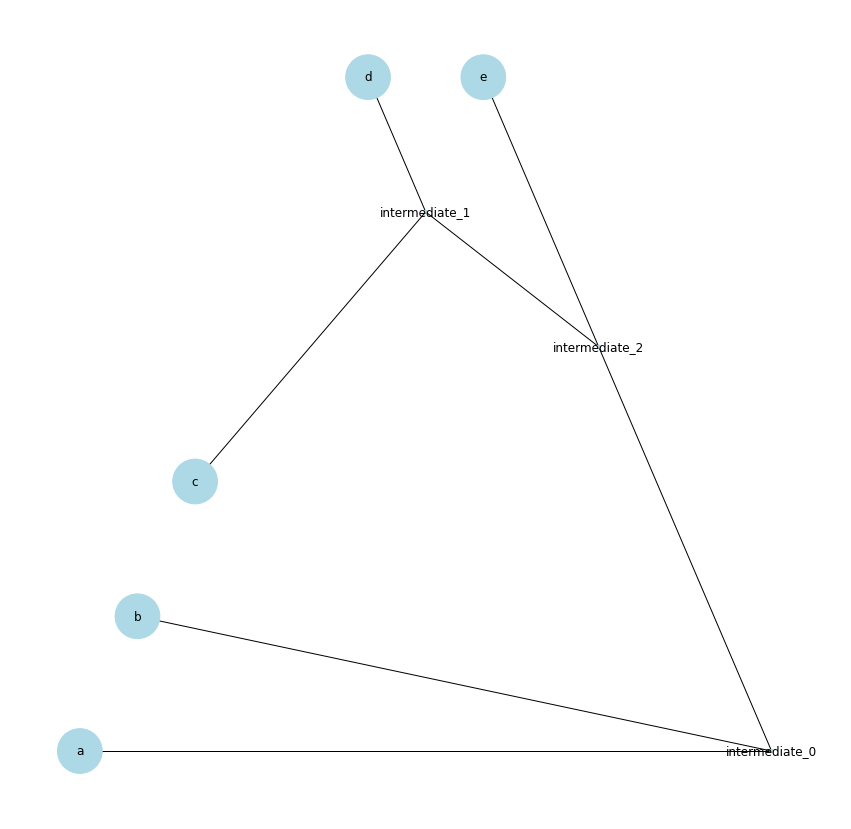

In [769]:
draw_graph_nice(G)
print(G.edges["intermediate_0","intermediate_2"]["weight"])

In [619]:
# Get sequences
sequences, seq_names = utils.get_sequences_for_ancestry()

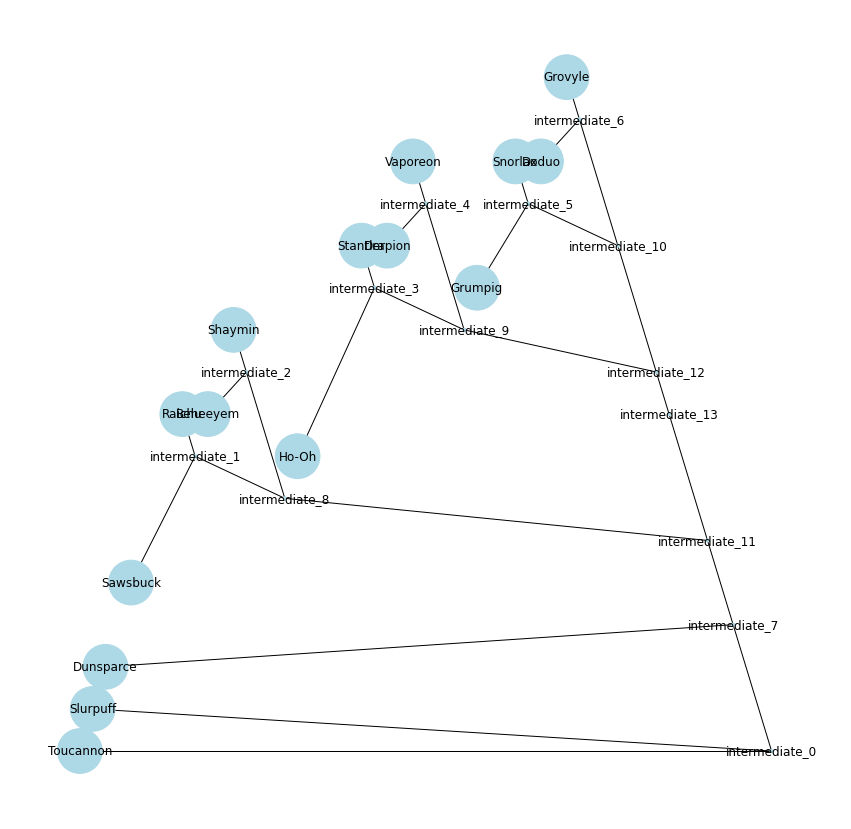

In [620]:
# Your code here
numPokemon = len(sequences)
distances = np.zeros((numPokemon,numPokemon))
for i in range(numPokemon):
    for j in range(i,numPokemon):
        distances[i,j] = showAlignmentG(sequences[i],sequences[j],affineGap, simpleMatch)[1][2]
        distances[j,i] = distances[i,j]
clear_output(wait=True)
G = construct_alignment(distances, seq_names)
draw_graph_nice(G)

        

<div class="alert alert-success">
    
**Problem 4 (b).** Given $n$ sequences each of roughly the same length $m$, what would the time complexity be for constructing such a phylogenetic tree? Can you think of any algorithms or heuristics that might make the process faster? 
    
</div>

O(n^3 + m^2n^2).  We need to calculate distances initially for each sequence which is n^2/2 pairwise comparisions that for each is an m^2 squared operation.  During the tree creation, we need to recompute distance matrices n times each with an order of n^2 comparisons for n^3.  One heuristic we could possibly use are the initial distance values we calculated, which might let you skip some work if they're sufficiently close the minimum already found instead of recalculating to find the minimum.

<div class="alert alert-success">

**Problem 4 (c).** Assume a direct correlation between the distance between any two nodes and the number of years (in millions) between their evolution. Assuming `Grumpig` was the first Pokémon to evolve, when did life first come to be in the fictional scenario?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [626]:
print(G.edges["Snorlax","intermediate_5"])

{'weight': 0.0}


In [31]:
how_long_ago = "???" # Replace with your answer
print(f"Life evolved {how_long_ago} million years ago in the Pokémon world")

Life evolved ??? million years ago in the Pokémon world


One way to test the robustness of such a tree reconstruction algorithm is to consider collection of nodes independently and see if the recontructed sub-trees match the bigger tree.

<div class="alert alert-success">
    
**Problem 4 (d).** Find an  edge between intermediate nodes with the largest weight in the phylogenetic tree and remove that edge- this will produce two disjoint cluster of nodes. Re-run your tree reconstruction algorithm on these two sets of Pokémons. Do your reconstructed tree match the larger phylogenetic tree?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [32]:
# Your code here

_Type your answer here_

<div class="alert alert-success">

**Problem 4 (d).** Can you inspect the matrix of distances between the Pokémons and predict whether the reconstructed trees would always be unique? Why/why not?
</div>

_Type your answer here_

## Part 5: Tracing Evolution

<div class="alert alert-warning">
    This problem is a "Challenge Problem". This means it is a problem of unknown difficulty that might be quite challenging (unlike the earlier problems, we don't have a reference solution for this one, or a clear idea how hard it might be). We do hope all students will at least attempt this and that more ambitious students will work hard to solve it and learn interesting things by the attempt (whether or not it is successful), but not get frustrated if you can't get to the desired answer.  As a "Challenge Problem" it means that you shouldn't be worried if you are not able to solve this, though, and you can get full expected credit on this assignment without answering it.
</div>


Now that we can construct Phylogenetic trees using sequence alignment, we can attempt to construct these trees for different organisms and trace their evolution through time. You're given reads processed from a FASTA file for Hemoglobin Beta Proteins, which can be used to then trace evolution based on how similar their sequences are across organisms from different kingdoms. Each record has the following relevant information in Tuple format:

`((uniprot identifier, full name, shortened name, group), (sequence))`

As you may notice, running our nearest-neighbor reconstruction algorithm on this data will give a Phylogenetic tree that does not fully correspond to what we know about the evolution of these species.

<div class="alert alert-success">
    
**Problem 8 (Challenge).** Construct a Phylogenetic Tree using the given sequences. Implement and use any tree-reconstruction method of your choice, and see if it works better than the nearest-neighbor method with a linear-gap penalty.
    
For visualization, use the short name to display in the evolution tree.
    
</div>
    
This is an open-ended question, and is inspired by https://www.mimuw.edu.pl/~lukaskoz/teaching/sad2/lab6/readme.html. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have.

In [33]:
sequences = utils.get_sequences_for_tree()
print(sequences[0])

(('P01941.1', 'Tupaia glis', 'Tgli', 'Mammalia'), 'VLSPGDKSNIKAAWGKIGGQAPQYGAEALERMFLSFPTTKTYFPHFDMSHGSAQIQAHGKKVADALSTAVGHLDDLPTALSALSDLHAHKLRVDPANFKLLSHCILVTLACHHPGDFTPEIHASLDKFLANVSTVLTSKYR')


In [ ]:
# Your code here

_Write a description of your algorithm, and things you learned from working on this here._

_Type your answer here_

<div class="alert alert-success">
    
Is this (using Hemoglobin proteins) the best way to trace and visualize evolution? Why do you think it is useful, and what could the possible downsides of this be?
    
</div>

_Type your answer here_

   <div class="alert alert-block alert-danger">
    <center>
      
**End of Project 2!**
        
Remember to follow the submission directions above and to submit your assignment by 7:59pm on Thursday, 24 February.
    
 </center>
 </div>